## 🧩 Transformer Design Space Description

Considering the gpt2-like decoder-only transformer structure, it would have the follow parameter config variations.

### **Table of Parameters**

| Symbol | Parameter | Description | 
|:--:|:--|:--|
| $d_{\text{n\_embd}}$ | Model dimension | Hidden size of layer $\ell$ |
| $n_{\text{n\_head}}$ | Attention heads | Number of parallel attention heads | 
| $\text{mlp\_ratio}$ | MLP expansion ratio | Expansion ratio in feedforward block | 
| $\text{block\_size}$ | Block size | Number of visible tokens per query | 
| $n_{\text{heads}}$ | Layers | Number of Layer |

Consider a homogeneous architecture (i.e. each layer shares the same setting), the search space could be configured in the following block

In [47]:
# Interactive search-space controls
!pip install ipywidgets
from ipywidgets import widgets
from IPython.display import display, clear_output


def show_config(max_n_layers,
                n_embd_min, n_embd_max, n_embd_step,
                mlp_min, mlp_max, mlp_step,
                bs_min, bs_max, bs_step,
                max_n_heads):
    print(f"Maximum number of layers: {max_n_layers}")
    print(f"Embedding dimension range: min={n_embd_min}, max={n_embd_max}, step={n_embd_step}")
    print(f"MLP ratio range: min={mlp_min}, max={mlp_max}, step={mlp_step}")
    print(f"Block size range: min={bs_min}, max={bs_max}, step={bs_step}")
    print(f"Maximum number of heads: {max_n_heads}")

    # Basic validation feedback
    errs = []
    if n_embd_step <= 0:
        errs.append("Embedding step must be > 0")
    if n_embd_min > n_embd_max:
        errs.append("Embedding min cannot be greater than max")

    if mlp_step <= 0:
        errs.append("MLP ratio step must be > 0")
    if mlp_min > mlp_max:
        errs.append("MLP ratio min cannot be greater than max")

    if bs_step <= 0:
        errs.append("Block size step must be > 0")
    if bs_min > bs_max:
        errs.append("Block size min cannot be greater than max")

    if errs:
        print("\nIssues:")
        for e in errs:
            print(" -", e)


# Wider labels so full names are visible
label_style = {"description_width": "initial"}

# Widgets with full names
w_max_n_layers = widgets.IntSlider(
    value=12, min=1, max=64, step=1,
    description="Max n_layers",
    style=label_style,
)

# Embedding (d_model) range
w_n_embd_min = widgets.IntText(
    value=256, description="Embedding dimension (min)",
    style=label_style,
)
w_n_embd_max = widgets.IntText(
    value=768, description="Embedding dimension (max)",
    style=label_style,
)
w_n_embd_step = widgets.IntText(
    value=64, description="Embedding dimension (step)",
    style=label_style,
)

# MLP ratio range
w_mlp_min = widgets.IntText(
    value=1, description="MLP ratio (min)",
    style=label_style,
)
w_mlp_max = widgets.IntText(
    value=8, description="MLP ratio (max)",
    style=label_style,
)
w_mlp_step = widgets.IntText(
    value=1, description="MLP ratio (step)",
    style=label_style,
)

# Block size range
w_bs_min = widgets.IntText(
    value=256, description="Block size (min)",
    style=label_style,
)
w_bs_max = widgets.IntText(
    value=2048, description="Block size (max)",
    style=label_style,
)
w_bs_step = widgets.IntText(
    value=64, description="Block size (step)",
    style=label_style,
)

# Heads
w_max_n_heads = widgets.IntSlider(
    value=8, min=1, max=64, step=1,
    description="Max n_heads",
    style=label_style,
)

ui = widgets.VBox([
    w_max_n_layers,
    widgets.HBox([w_n_embd_min, w_n_embd_max, w_n_embd_step]),
    widgets.HBox([w_mlp_min, w_mlp_max, w_mlp_step]),
    widgets.HBox([w_bs_min, w_bs_max, w_bs_step]),
    w_max_n_heads,
])

out = widgets.Output()


def _refresh_output(*_):
    with out:
        clear_output(wait=True)
        show_config(
            w_max_n_layers.value,
            w_n_embd_min.value, w_n_embd_max.value, w_n_embd_step.value,
            w_mlp_min.value, w_mlp_max.value, w_mlp_step.value,
            w_bs_min.value, w_bs_max.value, w_bs_step.value,
            w_max_n_heads.value,
        )


for _w in [
    w_max_n_layers,
    w_n_embd_min, w_n_embd_max, w_n_embd_step,
    w_mlp_min, w_mlp_max, w_mlp_step,
    w_bs_min, w_bs_max, w_bs_step,
    w_max_n_heads,
]:
    _w.observe(_refresh_output, names="value")

_refresh_output()

# Apply button to save into variables
apply_btn = widgets.Button(description="Apply to variables", button_style="success")
status = widgets.HTML()


def _on_apply_clicked(_):
    global max_n_layers, n_embd, mlp_ratio, block_size, max_n_heads, config

    # Validate before save
    errs = []
    if w_n_embd_step.value <= 0:
        errs.append("Embedding step must be > 0")
    if w_n_embd_min.value > w_n_embd_max.value:
        errs.append("Embedding min cannot be greater than max")

    if w_mlp_step.value <= 0:
        errs.append("MLP ratio step must be > 0")
    if w_mlp_min.value > w_mlp_max.value:
        errs.append("MLP ratio min cannot be greater than max")

    if w_bs_step.value <= 0:
        errs.append("Block size step must be > 0")
    if w_bs_min.value > w_bs_max.value:
        errs.append("Block size min cannot be greater than max")

    if errs:
        status.value = "<span style='color:red'>" + "; ".join(errs) + "</span>"
        return

    max_n_layers = w_max_n_layers.value
    max_n_heads = w_max_n_heads.value
    n_embd = {
        "min": w_n_embd_min.value,
        "max": w_n_embd_max.value,
        "step": w_n_embd_step.value,
    }
    mlp_ratio = {
        "min": w_mlp_min.value,
        "max": w_mlp_max.value,
        "step": w_mlp_step.value,
    }
    block_size = {
        "min": w_bs_min.value,
        "max": w_bs_max.value,
        "step": w_bs_step.value,
    }
    config = dict(
        max_n_layers=max_n_layers,
        n_embd=n_embd,
        mlp_ratio=mlp_ratio,
        block_size=block_size,
        max_n_heads=max_n_heads,
    )

    status.value = (
        "<span style='color:green'>Saved: max_n_layers, n_embd {min,max,step}, mlp_ratio {min,max,step}, "
        "block_size {min,max,step}, max_n_heads, and config</span>"
    )


apply_btn.on_click(_on_apply_clicked)

display(ui, out, apply_btn, status)


Output()

Button(button_style='success', description='Apply to variables', style=ButtonStyle())

HTML(value='')

## Check the Search Space Configuration

In [67]:
# Example: use the saved variables
try:
    print("max_n_layers:", max_n_layers)
    print("n_embd:", n_embd)
    print("max_n_heads:", max_n_heads)
    print("\nConfig dict:", config)
except NameError:
    print("Variables not set yet. Run the previous cell and click 'Apply to variables'.")

max_n_layers: 8
n_embd: {'min': 512, 'max': 2048, 'step': 128}
max_n_heads: 32

Config dict: {'max_n_layers': 8, 'n_embd': {'min': 512, 'max': 2048, 'step': 128}, 'mlp_ratio': {'min': 1, 'max': 8, 'step': 1}, 'block_size': {'min': 512, 'max': 1024, 'step': 256}, 'max_n_heads': 32}


## Define the Search Space -- Homogeneous Architecture

In [68]:
# Import the search_space.py next to this notebook's folder and build a space from the UI variables
import sys
from pathlib import Path
import importlib

# Ensure the nsga_search directory (parent of this notebook) is on sys.path
nb_dir = Path().resolve()              # .../nsga_search/notebooks
src_dir = nb_dir.parent                # .../nsga_search
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

# Force fresh import/reload so recent edits in search_space.py are picked up
if 'search_space' in sys.modules:
    del sys.modules['search_space']
import search_space as ss
ss = importlib.reload(ss)
print("Using search_space module at:", ss.__file__)
print("Last modified:", Path(ss.__file__).stat().st_mtime)

# Build specs from interactive values and instantiate the search space
try:
    # Globals belong in globals_spec
    gspec = {
        "d_model": {"type": "int", "low": n_embd["min"], "high": n_embd["max"], "step": n_embd["step"]},
    }
    # Per-layer fields go into layer_spec
    lspec = {
        "n_heads": {"type": "int", "low": 1, "high": max_n_heads, "step": 1},
        "block_size": {"type": "int", "low": block_size["min"], "high": block_size["max"], "step": block_size["step"]},
        "mlp_ratio": {"type": "int", "low": mlp_ratio["min"], "high": mlp_ratio["max"], "step": mlp_ratio["step"]},
        "attn_type": {"type": "cat", "choices": ["mha"]},
    }

    space = ss.HeteroSearchSpace.from_dicts(gspec, lspec, L_max=1) # Set L_max=1 for repeating layers
    print("Search space ready. L_max =", max_n_layers)

    # Quick sample to verify integration
    # ind = space.sample()
    # ind.print_individual(max_layers=4)
except NameError:
    print("Variables not set yet. Run the interactive cell above and click 'Apply to variables'.")

num_configs = 0 

for n_embdin in range(n_embd["min"], n_embd["max"] + 1, n_embd["step"]):
    for n_heads in range(1, max_n_heads + 1):
        if n_embdin % n_heads == 0:
            num_configs += (mlp_ratio["max"] - mlp_ratio["min"] + 1) * ((block_size["max"] - block_size["min"]) // block_size["step"] + 1)
            
num_configs *= max_n_layers  # arbitrary number of layers, each can be any of the configurations

print(f"Number of possible configurations in the search space: {num_configs}")


Using search_space module at: /Users/evansjiang/Desktop/Work/Brown/repo/Evo_GPT/optimization_and_search/nsga_search/search_space.py
Last modified: 1759888158.8155668
Search space ready. L_max = 8
Number of possible configurations in the search space: 22464


### Histogram of the model size in the search space

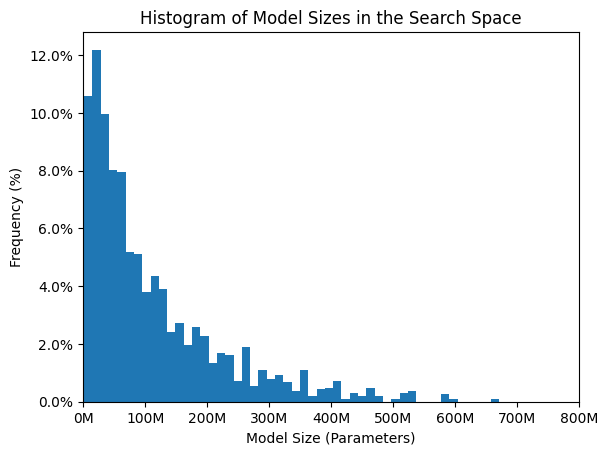

In [80]:
sizes = []


def calculate_model_size(n_embd, n_heads, mlp_ratio, block_size, num_layers):
    # Simplified model size calculation (in parameters)
    d_ff = n_embd * mlp_ratio
    size_per_layer = (4 * n_embd * n_embd) + (n_embd * d_ff * 2)  # Attention + MLP
    total_size = size_per_layer * num_layers
    return total_size


for n_embdin in range(n_embd["min"], n_embd["max"] + 1, n_embd["step"]):
    for n_heads in range(1, max_n_heads + 1):
        if n_embdin % n_heads == 0:
            for mr in range(mlp_ratio["min"], mlp_ratio["max"] + 1, mlp_ratio["step"]):
                for bk in range(block_size["min"], block_size["max"] + 1, block_size["step"]):
                    for layer in range(1, max_n_layers + 1):
                        model_size = calculate_model_size(n_embdin, n_heads, mr, bk, layer)
                        sizes.append(model_size)

!pip install matplotlib numpy
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Plot histogram with percentages instead of counts
total = len(sizes)
weights = [100.0/total] * total if total > 0 else None
plt.hist(sizes, bins=50, weights=weights)
plt.xlabel('Model Size (Parameters)')
plt.ylabel('Frequency (%)')
plt.title('Histogram of Model Sizes in the Search Space')

# Format y-axis as percentage
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))

# Start x-axis at 0 and format in millions
plt.xlim(left=0)
_ticks, _ = plt.xticks()
plt.xticks(ticks=_ticks, labels=[f"{int(x/1e6)}M" for x in _ticks])

plt.show()

## Transition to Heterogenous Search Space 

Keep the same range for the parameters, but make they variable per layer (expect n_embd remains global setting)

In [ ]:
# Build specs from interactive values and instantiate the search space
try:
    # Globals belong in globals_spec
    gspec = {
        "d_model": {"type": "int", "low": n_embd["min"], "high": n_embd["max"], "step": n_embd["step"]},
    }
    # Per-layer fields go into layer_spec
    lspec = {
        "n_heads": {"type": "int", "low": 1, "high": max_n_heads, "step": 1},
        "block_size": {"type": "int", "low": block_size["min"], "high": block_size["max"], "step": block_size["step"]},
        "mlp_ratio": {"type": "int", "low": mlp_ratio["min"], "high": mlp_ratio["max"], "step": mlp_ratio["step"]},
        "attn_type": {"type": "cat", "choices": ["mha"]},
    }

    space = ss.HeteroSearchSpace.from_dicts(gspec, lspec, L_max=max_n_layers) # Set L_max=1 for repeating layers
    print("Search space ready. L_max =", max_n_layers)

    # Quick sample to verify integration
    # ind = space.sample()
    # ind.print_individual(max_layers=4)
except NameError:
    print("Variables not set yet. Run the interactive cell above and click 'Apply to variables'.")
    
num_configs_het = 0 

for n_embdin in range(n_embd["min"], n_embd["max"] + 1, n_embd["step"]):
    for n_heads in range(1, max_n_heads + 1):
        if n_embdin % n_heads == 0:
            num_configs_het += (mlp_ratio["max"] - mlp_ratio["min"] + 1) * ((block_size["max"] - block_size["min"]) // block_size["step"] + 1)
            
num_configs_het = num_configs_het ** max_n_layers  # Each layer can be any of the configurations

# use scientific notation if too large
print(f"Number of possible configurations in the search space: {num_configs_het:.2e} {num_configs_het // num_configs :.2e}x larger than the homogeneous space")

Search space ready. L_max = 8
Number of possible configurations in the search space: 3.87e+27 1.72e+23x larger than the homogeneous space


## Estimate Distribution of Model Sizes by Fast Convolution

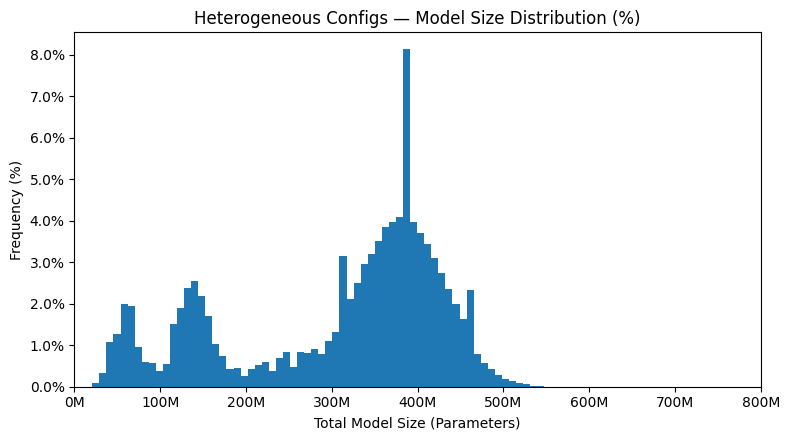

In [83]:

# -----------------------------------------------------------------------------
# Efficient distribution of total model sizes across ALL heterogeneous configs
# without brute force enumeration. We use a convolution trick: the total model
# size for L layers is L*base + coeff * sum(mlp_ratio_ell), where
#   base  = 4 * d_model^2,
#   coeff = 2 * d_model^2, and mlp_ratio_ell comes from a small discrete set.
# The distribution of the sum over L layers is the L-fold convolution of a
# uniform discrete pmf over the allowed mlp_ratio values. We then form a
# mixture over all allowed d_model with weights proportional to
# (valid_heads(d_model) * num_block_sizes)^L. Finally, we plot percentages.
# -----------------------------------------------------------------------------
try:
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import PercentFormatter

    L = int(max_n_layers)
    mlp_min = mlp_ratio["min"]; mlp_max = mlp_ratio["max"]; mlp_step = mlp_ratio["step"]
    mlp_vals = np.arange(mlp_min, mlp_max + 1, mlp_step)
    K = len(mlp_vals)

    if K <= 0 or L <= 0:
        print("Cannot plot distribution: empty mlp_ratio range or invalid L.")
    else:
        # Base pmf for a single layer over indices 0..K-1 (uniform)
        base = np.ones(K, dtype=np.float64) / K

        def conv_pow(p, e):
            # Fast exponentiation of 1D convolution in probability space
            res = np.array([1.0], dtype=np.float64)  # delta at 0
            b = p.copy()
            ee = int(e)
            while ee > 0:
                if ee & 1:
                    res = np.convolve(res, b)
                b = np.convolve(b, b)
                ee >>= 1
            return res

        # pmf over the sum of L i.i.d. uniform discrete variables on {0..K-1}
        pmf_R = conv_pow(base, L)  # length = L*(K-1)+1
        # Map indices to actual sum of mlp ratios: R = L*mlp_min + idx*mlp_step
        idx = np.arange(len(pmf_R))
        R_vals = L * mlp_min + idx * mlp_step

        # Mixture over all allowed d_model values, weighted by (heads*block)^L
        n_vals = list(range(n_embd["min"], n_embd["max"] + 1, n_embd["step"]))
        B = 1

        def count_valid_heads(n, h_max):
            return sum(1 for h in range(1, h_max + 1) if n % h == 0)

        # Compute mixture weights in log-space to avoid overflow
        log_ws = []
        for n in n_vals:
            Hn = count_valid_heads(n, max_n_heads)
            M = max(Hn, 0) * max(B, 0)
            if M <= 0:
                log_ws.append(float("-inf"))
            else:
                log_ws.append(L * np.log(M))
        max_log = np.max(log_ws)
        if not np.isfinite(max_log):
            print("No valid per-layer combinations to form heterogeneous configs.")
        else:
            ws_scaled = np.exp(np.array(log_ws) - max_log)
            alpha = ws_scaled / ws_scaled.sum()  # mixture coefficients sum to 1

            sizes_all = []
            weights_all = []
            for n, a in zip(n_vals, alpha):
                n2 = float(n) * float(n)
                # Total parameters for sum R: S = 2*n^2 * (2L + R)
                S_vals = 2.0 * n2 * (2 * L + R_vals)
                sizes_all.append(S_vals)
                weights_all.append(a * pmf_R)  # a is mixture weight, pmf_R sums to 1

            sizes_all = np.concatenate(sizes_all)
            weights_all = np.concatenate(weights_all)

            # Convert to percentages
            weights_all = 100.0 * (weights_all / weights_all.sum())

            # Plot a weighted histogram (percent) with smart binning
            bins = 80  # keep modest to avoid over-plotting
            plt.figure(figsize=(8, 4.5))
            plt.hist(sizes_all, bins=bins, weights=weights_all)
            plt.xlabel('Total Model Size (Parameters)')
            plt.ylabel('Frequency (%)')
            plt.title('Heterogeneous Configs — Model Size Distribution (%)')
            plt.xlim(left=0)
            # Format x-axis in millions
            xticks, _ = plt.xticks()
            plt.xticks(ticks=xticks, labels=[f"{int(x/1e6)}M" for x in xticks])
            ax = plt.gca()
            ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
            plt.tight_layout()
            plt.show()
except NameError:
    print("Variables not set yet. Run the interactive cell above and click 'Apply to variables'.")